# Well data processing

In [2]:
from pathlib import Path
import os
import sys
import numpy as np
from matplotlib import pyplot as plt
import lasio
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
import glob
from scipy.stats import mode
import warnings
sns.set(color_codes=True)

In [3]:
workdir = Path('../')
lasdir = workdir.joinpath('data','las_MPWSP')
# lasdir = workdir.joinpath('data','las_all')

auxdir=  workdir.joinpath('data','auxiliary')
figdir=  workdir.joinpath('work','figs')

In [32]:
def myround(x, base=.5):
    return base*np.round(x/base)
def mask_nonan(df,nan_col_list):
    mask = df.notnull()
    return mask.loc[:,nan_col_list].all(axis=1)

def mask_noclay(df,nan_col_list):
    return ~df.loc[mask_nonan(df,nan_col_list),'lith'].str.contains("C")

def mask_SP_only(df,nan_col_list):
    return df.loc[mask_nonan(df,nan_col_list),'lith']=="SP"

def mask_stds(df,nstds,testcol,nan_col_list):
    pop = df.loc[mask_nonan(df,nan_col_list),testcol]
    return  np.logical_and(pop < np.mean(pop)+nstds*np.std(pop),
                           pop > np.mean(pop)-nstds*np.std(pop))
def mask_wherescreen(df,nan_col_list):
    return  mask_nonan(df[df.screen.notnull()],nan_cols)

def tds2rho_est(tds,m=.692826,b=-220.28):
    return 1e4*m/(tds-b)

def rho2tds_est(rho,m=.692826,b=-220.28):
    return 1e4*m/rho + b

def cond2rho(cond):
    return 1e4/cond
    
def nested_logicals(df,list_of_conditions,func=np.logical_and):
    '''
    Convenience function to nest numpy logical functions
        Input: 
            df
            list_of_conditions
            func: numpy function to be applied
        Output:
            logical mask for the given dataframe
        '''
    out = np.ones(len(list_of_conditions[0]),dtype=bool)
    for i in range(len(list_of_conditions)):
        out = func(out,list_of_conditions[i])
    return out

def interpIntervals(df,interp_cols,group_cols=['Well','Year'],dept_col='DEPT',interval=.5):
    '''
    Interpolates numerical values to a specified resolution (interval) 
    Meant for use with depth-registered well data
        Input:
            df: DataFrame
            interp_cols: list
            group_cols: list
            dept_col: str
            interval: numeric
        Output:
            DataFrame with interpolated rows
    '''
    frames = []
    for key,group in df.groupby(by=group_cols):

        all_cols = group.columns
        dup_cols=[col for col in all_cols if (col not in (interp_cols+[dept_col]))]

        #interpolation
        x_eval = np.arange(group.loc[:,dept_col].values[0],group.loc[:,dept_col].values[-1]+interval,interval)
        xp = group.loc[:,dept_col].values
        y_eval={}
        for col in interp_cols:
            yp = group.loc[:,col].values
            y_eval[col]=np.interp(x_eval,xp,yp)

        #create new DF
        df_out = pd.DataFrame(columns=all_cols)
        df_out = df_out.append([df.loc[group.index[0],dup_cols]]*len(x_eval))
        for col in interp_cols:
            df_out.loc[:,col] = y_eval[col]
        df_out.loc[:,dept_col] = x_eval

        #concatenate frames
        frames.append(df_out)
    return pd.concat(frames).reset_index(drop=True)

def concat_dfs(dfs):
    dfs = [sc_df_interp,df2]
    new_dfs = []
    maxind= 0

    for df in dfs:
        df_index = df.index.values + maxind + 1
        maxind = np.max(df_index)
        df.loc[:,'new_index'] = df_index
        df.set_index('new_index',inplace=True)
        new_dfs.append(df)
    return pd.concat(new_dfs,axis=0,sort=True)

def update_df2():
    return df.reset_index().rename(columns={"level_0": "Well"})

def update_FBS(df,TDS_col):
    FBS = np.zeros(len(df))
    FBS[df.loc[:,TDS_col].isna()] = np.nan
    FBS[df.loc[:,TDS_col] <= 3000] = 1
    FBS[np.logical_and(df.loc[:,TDS_col] > 3000,df.loc[:,TDS_col] < 10000)] = 2
    FBS[df.loc[:,TDS_col] >= 10000] = 3
    return df.assign(FBS=FBS)

def m2ft(df,colname,newcolname=None):
    if newcolname is None:
        newcolname = colname + 'ft'
    df[newcolname] = df[colname]/.3048
    return

def interval2point(pointdf,intervaldf,testcol,topcol='topft',botcol='botft'):
    df_list = []
    for d in pointdf.index:
        v=intervaldf[((d>=intervaldf[topcol]) & (d<intervaldf[botcol]))][testcol]
        if len(v)==1:
            df_list.append(v.values[0])
        elif len(v)>1:
            print(v)
            raise Exception('multiple values in this interval ??')
        else:
            df_list.append(np.nan)
    return df_list


In [33]:
recompute = False
clip_bad_data=True

if not recompute:
    df =  pd.read_pickle(lasdir.joinpath('allMWs'))
    df_ind =  pd.read_pickle(lasdir.joinpath('allMWs_ind'))
    MWnames = df.index.levels[0].values
else:
    f_MWm = glob.glob(lasdir.joinpath('*[1-9]m.las').as_posix())
    for f in f_MWm:
        lasobj = lasio.read(f)
        lasexpt = lasio.LASFile()

        for c in lasobj.curves:
            if c.mnemonic=='DEPT':
                continue
            lasexpt.insert_curve_item(0,c)
        #make sure DEPT is the first curve for aesthetics
        d = lasobj.get_curve('DEPT')
        d_mode = mode(np.diff(np.round(d.data/.3048,decimals=2))).mode[0]
        if d_mode==0.5:
            lasexpt.insert_curve(0,'DEPT',myround(d.data/.3048,base=.5),unit='F')
            lasexpt.write(f[:-5]+'_all.las')
        else:
            raise Exception('Needs to be .5 feet')

    ########## Create list of DataFrames
    f_MWall = glob.glob(lasdir.joinpath('*_all.las').as_posix())
    f_MWall = sorted(f_MWall,key=os.path.basename)
    MWnames = [Path(f).stem[:-4] for f in f_MWall]

    frames = []
    for f in f_MWall:
        las = lasio.read(f)
        #Convert to DF and mask for plots
        df_temp = las.df()
        frames.append(df_temp)

    ######### Meters to feet for lith and screen
    def m2ft(df,colname,newcolname=None):
        if newcolname is None:
            newcolname = colname + 'ft'
        df[newcolname] = df[colname]/.3048
        return

    mwcollar = pd.read_excel(auxdir.joinpath('MPWSP_Collar.xlsx'))
    mwlith= pd.read_excel(auxdir.joinpath('Lith_MPWSP.xlsx'))
    mwtds= pd.read_excel(auxdir.joinpath('TDS_Baseline_MPWSP.xlsx'),index_col=0)
    mwscreen = pd.read_excel(auxdir.joinpath('MPWSP_Screen.xlsx'),index_col=0)
    mwchem = pd.read_excel(auxdir.joinpath('WQ_Baseline_MPWSP.xlsx'),index_col=0)
    wellids = np.unique(mwlith['WellID'])


    m2ft(mwlith,'Top_m','topft')
    m2ft(mwlith,'Bottom_m','botft')
    m2ft(mwscreen,'Screen_Top','topft')
    m2ft(mwscreen,'Screen_Bottom','botft')
    
    for i,frame in enumerate(frames):
        nam = MWnames[i]
        print('processing',nam)
        TDS1_list = np.nan*np.zeros(len(frame))
        TDS2_list = np.nan*np.zeros(len(frame))
        EC1_list = np.nan*np.zeros(len(frame))
        EC2_list = np.nan*np.zeros(len(frame))
        EC1f_list = np.nan*np.zeros(len(frame))
        EC2f_list = np.nan*np.zeros(len(frame))
        TMPf1_list = np.nan*np.zeros(len(frame))
        TMPf2_list = np.nan*np.zeros(len(frame))

        #Assign X and Y
        frame = frame.assign(X=mwcollar.loc[mwcollar.Well==nam,'X'].values[0]*np.ones(len(frame)))
        frame = frame.assign(Y=mwcollar.loc[mwcollar.Well==nam,'Y'].values[0]*np.ones(len(frame)))
        frame = frame.assign(Region=list(mwcollar.loc[mwcollar.Well==nam,'Region'].values)*len(frame))

        #Assign lith
        lith_list = interval2point(frame,mwlith.loc[lambda df: df['WellID'] == nam]
                   ,'Lith_Code_Orig',topcol='topft',botcol='botft')
        frame = frame.assign(lith=lith_list)

        #Assign screen and aquifer name
        screen_list = interval2point(frame,mwscreen.loc[lambda df: df.index == nam]
                   ,'Alt_ID',topcol='topft',botcol='botft')
        screen_len_list = interval2point(frame,mwscreen.loc[lambda df: df.index == nam]
                   ,'Screen_Len_ft',topcol='topft',botcol='botft')
        aq_list = interval2point(frame,mwscreen.loc[lambda df: df.index == nam]
                   ,'TargetedAquifer',topcol='topft',botcol='botft')
        aq_group_list = interval2point(frame,mwscreen.loc[lambda df: df.index == nam]
                   ,'GroupedAquifer',topcol='topft',botcol='botft')

        frame = frame.assign(screen=screen_list)
        frame = frame.assign(screen_len=screen_len_list)
        frame = frame.assign(Aquifer=aq_list)
        frame = frame.assign(AquiferGroup=aq_group_list)

        #Assign TDS measurements to each screen
        for scrn in frame.screen.dropna().unique():
            framebool = frame['screen']==scrn #entries in frame matching the well and screen
            screenbool = np.logical_and(mwtds.index == nam,mwtds['WellScreen'] == scrn) #matching entries in mwtds
            chembool = np.logical_and(mwchem.index == nam,mwchem['WellScreen'] == scrn)
            nmeas = len(mwtds.loc[screenbool,'TDS(mg/L)'])
            if nmeas==2:
                TDS1_list[framebool] =mwtds.loc[screenbool,'TDS(mg/L)'].iloc[0]
                TDS2_list[framebool] =mwtds.loc[screenbool,'TDS(mg/L)'].iloc[1]     
                EC1_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C)'].iloc[0]
                EC2_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C)'].iloc[1] 
                EC1f_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C) (FIELD)'].iloc[0]
                EC2f_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C) (FIELD)'].iloc[1] 
                TMPf1_list[framebool] =mwchem.loc[chembool,'TEMPERATURE, (FIELD)'].iloc[0]
                TMPf2_list[framebool] =mwchem.loc[chembool,'TEMPERATURE, (FIELD)'].iloc[1] 
            elif nmeas==1:
                TDS1_list[framebool] =mwtds.loc[screenbool,'TDS(mg/L)'].iloc[0]
                try:
                    TMPf1_list[framebool] =mwchem.loc[chembool,'TEMPERATURE, (FIELD)'].iloc[0]
                    EC1_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C)'].iloc[0]
                    EC1f_list[framebool] =mwchem.loc[chembool,'SPECIFIC CONDUCTANCE (E.C) (FIELD)'].iloc[0]
                except:
                    print("No chem data found for well {} screen {}".format(nam,scrn))
            else:
                print('Num of measurements:',nmeas)
                raise Exception('Number of measurements not equal to 1 or 2')

        frame = frame.assign(TDS1=TDS1_list)
        frame = frame.assign(TDS2=TDS2_list)
        frame = frame.assign(EC1=EC1_list)
        frame = frame.assign(EC2=EC2_list)
        frame = frame.assign(EC1f=EC1f_list)
        frame = frame.assign(EC2f=EC2f_list)
        frame = frame.assign(TMPf1=TMPf1_list)
        frame = frame.assign(TMPf2=TMPf2_list)
        frame[frame.loc[:,['TDS1','TDS2','EC1','EC2','EC1f','EC2f','TMPf1','TMPf2']]==0]=np.nan

        topbot = [('MW-1D',100 ,330),
           ('MW-4D',0   ,327.5),
           ('MW-5D',75   ,426.5),
           ('MW-6D',40   ,400),
           ('MW-7D',71.0  ,345),
           ('MW-8D',30   ,350),
           ('MW-9D',71.0   ,392)]

        if clip_bad_data:
            for clipnam,top,bot in topbot:
                if clipnam==nam:
                    frame.loc[np.logical_or(frame.index<np.float(top),
                                            frame.index>np.float(bot))] = np.nan

        #Assign to list
        frames[i] = frame

    ######### Join all frames together
    df = pd.concat(frames, keys=MWnames, sort=False)


    ######### Replace 'Gravelly/silty sand w/clay' with 'SC-SM'
    df.loc[df.lith == 'Gravelly/silty sand w/clay','lith'] = 'SC-SM'

    ######### Add FRESc
    def degc2f(degc):
        return (degc*9/5)+32
    ref_temp= 77 #fahrenheit
    fresc = df.loc[:,'FRES']*(df.loc[:,'TMP']+6.77)/(ref_temp + 6.77)
    df=df.assign(FRESc = fresc);
    ec_fresc = cond2rho(df.loc[:,'EC1f'])*(degc2f(df.loc[:,'TMPf1'])+6.77)/(ref_temp + 6.77)
    df=df.assign(ec_fresc=ec_fresc)

#     ######### Add aquifer number
#     aqnum = -1*np.ones(len(df),dtype='Int32')
#     aq_names = df[df.Aquifer.notna()].Aquifer.unique()
#     aq_names.sort()
#     for i,aq in enumerate(aq_names):
#         aqnum[df.Aquifer == aq_names[i]] = i

#     df=df.assign(aqnum=aqnum)
    
    ######### Save DF
    df_ind = pd.DataFrame(df.index.tolist(), columns=['Well','DEPT'])

    df.to_pickle(lasdir.joinpath('allMWs'))
    df_ind.to_pickle(lasdir.joinpath('allMWs_ind'))
    print('Done reprocessing from raw data!')

### Get Soquel Creek data and interpolate to .5 feet

In [34]:
sc_df = pd.read_excel(auxdir.joinpath('SoquelCreek.xlsx'))
sc_df_interp = interpIntervals(sc_df,interp_cols = ['RILD'],group_cols=['Well','Year'],dept_col='DEPT',interval=.5)
sc_df_interp.to_pickle(lasdir.joinpath('SoquelCreek'))


df2 = update_df2()
df2.to_pickle(lasdir.joinpath('allMWs_df2'))

# df = concat_dfs((df2,sc_df_interp.set_index(['Well','DEPT'])))
df = pd.concat((df,sc_df_interp.set_index(['Well','DEPT'])),sort=False)

#Add Rw_est
Rw_est = np.zeros(len(df))
Rw_est[~df.TDS1.isna()] = tds2rho_est(df[~df.TDS1.isna()].TDS1)
Rw_est[~df.EC1f.isna()]=cond2rho(df[~df.EC1f.isna()].EC1f)
Rw_est[df.TDS1.isna()]=np.nan
df = df.assign(Rw_est=Rw_est)

df_ind = pd.DataFrame(df.index.tolist(), columns=['Well','DEPT'])
df.to_pickle(lasdir.joinpath('allMWs_SC'))
df_ind.to_pickle(lasdir.joinpath('allMWs_SC_ind'))
print('Done reprocessing from raw data!')

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


Done reprocessing from raw data!


In [41]:
df2.Well.unique()

array(['CX-B1', 'CX-B2', 'CX-B4', 'MDW-1', 'ML-1', 'ML-2', 'ML-3', 'ML-4',
       'ML-6', 'MW-1D', 'MW-4D', 'MW-5D', 'MW-6D', 'MW-7D', 'MW-8D',
       'MW-9D', 'PR-1', 'SC-8A', 'SC-8B', 'SC-8C', 'SC-8D', 'SC-8E',
       'SC-8F', 'SC-9D', 'SC-9I', 'SC-9S', 'SC-A2D', 'SC-A2I', 'SC-A2S',
       'SC-A8D', 'SC-A8I', 'SC-A8S'], dtype=object)

### 4 lithology categories applied to bagged trees

In [40]:
lithnum = np.zeros(len(df),dtype=np.int32)
lithnum_red = np.zeros(len(df),dtype=np.int32)
lithnum_bin= np.zeros(len(df),dtype=np.int32)
lithnum_bin_a =np.zeros(len(df),dtype=np.int32)
lithnum_bin_b = np.zeros(len(df),dtype=np.int32)
lithnum_bin_2ft= np.zeros(len(df),dtype=np.int32)



lithnam = [l for l in df.lith.unique() if str(l)!='nan']
lithnam.sort()


#4 lithologies (groups from UCSC)
lithnam_red = ['C','G','M','S']
lithnam2red = np.zeros(np.size(lithnam),dtype=np.int)


for i,redlith in enumerate(lithnam_red):
    for j,lith in enumerate(lithnam):
        if lith.startswith(redlith):
            lithnam2red[lithnam.index(lith)]=i

#Binary: Set anything that contains "C" or starts with "M" as "Cb"; else "Sb"
lithnam_bin = ['Cb','Sb']          
lithnam2bin= np.ones(np.size(lithnam),dtype=np.int)
for j,lith in enumerate(lithnam):
    if ('C' in lith) or (lith.startswith('MH')):
        lithnam2bin[lithnam.index(lith)]=0

#Assign to df
for i,lith in enumerate(lithnam):
    lithnum[df.lith == lithnam[i]] = i
    lithnum_red[df.lith == lithnam[i]] = lithnam2red[lithnam.index(lithnam[i])]
    lithnum_bin[df.lith == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_a[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
#     lithnum_bin_b[df.lith_above == lithnam[i]] = lithnam2bin[lithnam.index(lithnam[i])]
    
df = df.assign(lithnum=lithnum)
df = df.assign(lithnum_red=lithnum_red)
df = df.assign(lithnum_bin=lithnum_bin)

df = df.assign(C=(lithnum_red==0).astype(np.int))
df = df.assign(G=(lithnum_red==1).astype(np.int))
df = df.assign(M=(lithnum_red==2).astype(np.int))
df = df.assign(S=(lithnum_red==3).astype(np.int))

df = df.assign(Cb=(lithnum_bin==0).astype(np.int))
df = df.assign(Sb=(lithnum_bin==1).astype(np.int))

df = df.assign(Cb_a=(lithnum_bin_a==0).astype(np.int))
df = df.assign(Sb_a=(lithnum_bin_a==1).astype(np.int))
df = df.assign(Cb_b=(lithnum_bin_b==0).astype(np.int))
df = df.assign(Sb_b=(lithnum_bin_b==1).astype(np.int))


### Moving average of lithology

In [43]:
#Running average
wellids = df.index.levels[0].values

lithnum_bin_conv = np.zeros(len(df))
lith_above = np.zeros(len(df))
lith_below = np.zeros(len(df))
N=3 #Filter length
ind1 = 0
for nam in wellids:
    x= df.loc[nam].lithnum_bin.values
    ind2  = len(x) + ind1
    test = np.convolve(x, np.ones((N,))/N, mode='valid')
    lithnum_bin_conv[ind1:ind2] = np.r_[x[:int((N-1)/2)],test,x[-int((N-1)/2):]] #assign the original lith values to edge
    lith_above[ind1:ind2] = np.r_[x[:-1],np.nan]
    lith_below[ind1:ind2] = np.r_[np.nan,x[1:]]
    ind1=ind2


df = df.assign(lith_above=lith_above)
df = df.assign(lith_below=lith_below)
df= df.assign(lithnum_bin_conv=lithnum_bin_conv)

### Moving average of $log_{10}(RILD)$

In [44]:
#Running average
from scipy.stats import hmean

wellids = df.index.levels[0].values
logrild_conv = np.zeros(len(df))
logrild_conv_h = np.zeros(len(df))

N=35 #Filter length, .5 foot spacing for each
ind1 = 0
for nam in wellids:
    x= np.log10(df.loc[nam].RILD.values)
    xh= 1/df.loc[nam].RILD.values
    
    nans = np.isnan(x)
    x_red = x[np.where(~nans)]
    x_red_h = xh[np.where(~nans)]

    test_out = np.zeros(len(x))
    test_out_h = np.zeros(len(x))
    
    ind2  = len(x) + ind1

    test = np.convolve(x_red, np.ones((N,))/N, mode='valid')
    test_h = np.convolve(x_red_h, np.ones((N,))/N, mode='valid')
    
    test_edges = np.log10(np.r_[x_red[:int((N-1)/2)],test,x_red[-int((N-1)/2):]]) #assign the original lith values to edge
    test_edges_h = np.log10(1/ (np.r_[x_red[:int((N-1)/2)],test,x_red[-int((N-1)/2):]]) ) #assign the original lith values to edge
    
    test_out[np.where(~nans)] = test_edges
    test_out[np.where(nans)] = np.nan

    test_out_h[np.where(~nans)] = test_edges_h
    test_out_h[np.where(nans)] = np.nan

    
    logrild_conv[ind1:ind2] = test_out
    logrild_conv_h[ind1:ind2] = test_out_h

    
    
    ind1=ind2
df = df.assign(logrild_conv=logrild_conv)
df = df.assign(logrild_conv_h=logrild_conv_h)

/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log10
/Users/ianpg/anaconda/envs/SWIenv/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log10


In [45]:
from scipy.interpolate import UnivariateSpline
df2=update_df2()

# df_plot = df2.loc[df2.RILD.notnull()]
# x = df_plot.loc[df_plot.Well=='MW-5D','DEPT'].values
# y = np.log10(df_plot.loc[df_plot.Well=='MW-5D','RILD'].values)

wellids = df.index.levels[0].values
logrild_spline = np.zeros(len(df))
logrild_splinec = np.zeros(len(df))

ind1 = 0
smoothing_factor = 10
for nam in wellids:
    if nam in df2.loc[df2.Region=='Marina','Well'].values:
        print(nam)
        d= df2.loc[df2.Well==nam,'DEPT'].values
        x= np.log10(df.loc[nam].RILD.values)    
        xc = np.log10(1/df.loc[nam].RILD.values) 
        
        nans = np.isnan(x)
        d_red = d[np.where(~nans)]
        x_red = x[np.where(~nans)]
        xc_red = xc[np.where(~nans)]

        test_out = np.zeros(len(x))
        test_outc = np.zeros(len(x))    
        ind2  = len(x) + ind1

        spl = UnivariateSpline(d_red,x_red)
        splc = UnivariateSpline(d_red,xc_red)

        spl.set_smoothing_factor(smoothing_factor)
        splc.set_smoothing_factor(smoothing_factor)

        test = spl(d_red)
        testc = splc(d_red)
        
        test_out[np.where(~nans)] = test
        test_out[np.where(nans)] = np.nan
        logrild_spline[ind1:ind2] = test_out
        
        test_outc[np.where(~nans)] = testc
        test_outc[np.where(nans)] = np.nan
        logrild_splinec[ind1:ind2] = test_outc
        
        ind1=ind2

df = df.assign(logrild_spline=logrild_spline)
df = df.assign(logcild_spline=logrild_splinec)

# df = df.assign(logrild_conv_h=logrild_conv_h)

CX-B1
CX-B2
CX-B4
MDW-1
ML-1
ML-2
ML-3
ML-4
ML-6
MW-1D
MW-4D
MW-5D
MW-6D
MW-7D
MW-8D
MW-9D
PR-1


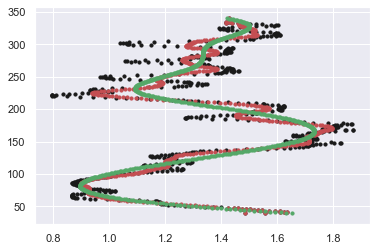

In [46]:
df2 = update_df2()
df_plot = df2
nam='MW-6D'
d=df_plot.loc[df_plot.Well==nam,'DEPT']

s1=plt.scatter(np.log10(df_plot.loc[df_plot.Well==nam,'RILD']),d,
            s=10, label='Bulk Res.',c='k')#df_plot.loc[df_plot.Well==nam,'C'])#,vmin= -0.078438,vmax=0.186663)

s2=plt.scatter(1/np.power(10,df_plot.loc[df_plot.Well==nam,'logrild_conv_h']),d,
            s=10, label='Bulk Res.',c='r')#df_plot.loc[df_plot.Well==nam,'C'])#,vmin= -0.078438,vmax=0.186663)

s2=plt.scatter(df_plot.loc[df_plot.Well==nam,'logrild_spline'],d,
            s=10, label='Bulk Res.',c='g')#df_plot.loc[df_plot.Well==nam,'C'])#,vmin= -0.078438,vmax=0.186663)

# s1=plt.scatter(np.power(10,df_plot.loc[df_plot.Well==nam,'logrild_conv']),d,
#             s=10, label='Bulk Res.',c='b')#df_plot.loc[df_plot.Well==nam,'C'])#,vmin= -0.078438,vmax=0.186663)


### Aquifer number

In [47]:
aq_groupnames = df[df.AquiferGroup.notna()].AquiferGroup.unique()
aq_names = df[df.Aquifer.notna()].Aquifer.unique()
aq_names.sort()
aq_groupnum = -1*np.ones(len(df),dtype='Int32')
aqnum = -1*np.ones(len(df),dtype='Int32')

for i,nam in enumerate(aq_groupnames):
    aq_groupnum[df.AquiferGroup == nam] = i
df=df.assign(aq_groupnum=aq_groupnum)

for i,aq in enumerate(aq_names):
    aqnum[df.Aquifer == aq_names[i]] = i
df=df.assign(aqnum=aqnum)

### Save

In [48]:
df2 = update_df2()
df2.to_pickle(lasdir.joinpath('allMWs_df2'))

# df = concat_dfs((df2,sc_df_interp.set_index(['Well','DEPT'])))
df = pd.concat((df,sc_df_interp.set_index(['Well','DEPT'])),sort=False)
df_ind = pd.DataFrame(df.index.tolist(), columns=['Well','DEPT'])
df.to_pickle(lasdir.joinpath('allMWs_SC'))
df_ind.to_pickle(lasdir.joinpath('allMWs_SC_ind'))
print('Done reprocessing from raw data!')

Done reprocessing from raw data!
